In [2]:
from pyod.models.iforest import IForest
import numpy as np
import pandas as pd 
import seaborn as sns 
import shap
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
df = pd.read_csv(r"C:\Users\user\Desktop\moniepoint\artifacts\data_ingestion\cleaned_anomaly_detection.csv")
df.head()

,row_id,original_log,datetime,user_id,transaction_type,amount,currency,location,device
0,1,2025-07-05 19:18:10::user1069::withdrawal::299...,2025-07-05 19:18:10,user1069,withdrawal,2995.12,GBP,London,iPhone 13
1,2,usr:user1076|cashout|€4821.85|Glasgow|2025-07-...,2025-07-15 12:56:05,user1076,cashout,4821.85,EUR,Glasgow,Pixel 6
2,3,2025-07-20 05:38:14 >> [user1034] did top-up -...,2025-07-20 05:38:14,user1034,top_up,2191.06,EUR,Unknown,iPhone 13
3,4,2025-06-13 10:04:51 >> [user1068] did deposit ...,2025-06-13 10:04:51,user1068,deposit,1691.09,EUR,Glasgow,Unknown
4,5,2025-07-29 23:47:37 | user: user1014 | txn: de...,2025-07-29 23:47:37,user1014,deposit,3539.50,GBP,Glasgow,iPhone 13


In [6]:
df = df.iloc[:, 2:]
df.head()

,datetime,user_id,transaction_type,amount,currency,location,device
0,2025-07-05 19:18:10,user1069,withdrawal,2995.12,GBP,London,iPhone 13
1,2025-07-15 12:56:05,user1076,cashout,4821.85,EUR,Glasgow,Pixel 6
2,2025-07-20 05:38:14,user1034,top_up,2191.06,EUR,Unknown,iPhone 13
3,2025-06-13 10:04:51,user1068,deposit,1691.09,EUR,Glasgow,Unknown
4,2025-07-29 23:47:37,user1014,deposit,3539.50,GBP,Glasgow,iPhone 13


In [9]:
import os
os.chdir("../")

%pwd

'c:\\Users\\user\\Desktop\\moniepoint'

In [10]:
from features.feature_engineering import FeatureEngineer
import matplotlib.pyplot as plt  
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [11]:
df = FeatureEngineer(df).engineer_batch()

In [13]:
print(df.shape)

(7774, 23)


In [14]:
from src.anomaly_detection.utils.common import convert_to_usd
## standardize the currency into one

df = convert_to_usd(df)
df.head()

,datetime,user_id,transaction_type,amount,currency,location,device,day_of_week,hour_of_day,month,quarter,is_weekend,day_of_month,is_business_hours,transaction_count_last_7_days,average_transaction_amount_last_10_days,days_since_last_transaction,unique_locations_used,new_device,amount_z_score_user,hours_since_last_transaction_user,transaction_count_today_user,amount_percentile_user
0,2025-06-01 12:03:31,user1000,cashout,2981.2100,USD,London,Samsung Galaxy S10,6,12,6,2,True,1,True,1.0,2981.210000,0.0,1,1,0.328784,0.000000,2,0.581081
1,2025-06-01 19:19:50,user1000,debit,1394.4370,EUR,Manchester,Xiaomi Mi 11,6,19,6,2,True,1,False,2.0,2124.440000,0.0,2,1,-0.814357,7.271944,2,0.297297
2,2025-06-02 19:52:44,user1000,refund,3610.6800,USD,Cardiff,Huawei P30,0,19,6,2,False,2,False,3.0,2619.853333,1.0,3,1,0.748718,24.548333,1,0.743243
3,2025-06-03 10:11:53,user1000,cashout,5823.8250,GBP,Birmingham,Nokia 3310,1,10,6,2,False,3,True,4.0,3129.655000,0.0,4,1,1.448116,14.319167,2,0.905405
4,2025-06-03 21:23:30,user1000,cashout,5079.9625,GBP,Liverpool,Nokia 3310,1,21,6,2,False,3,False,5.0,3316.518000,0.0,5,0,1.051118,11.193611,2,0.770270


In [15]:
## convert the booleans into float
df['is_business_hours'] = df['is_business_hours'].astype(float)
df['is_weekend'] = df['is_weekend'].astype(float)

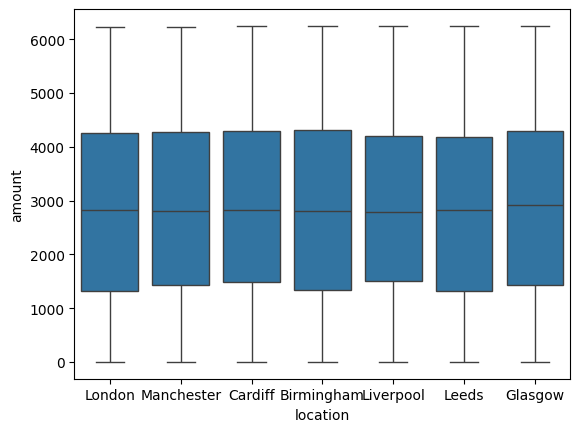

In [17]:
sns.boxplot(data=df, x=df['location'], y = df['amount'])
plt.show()

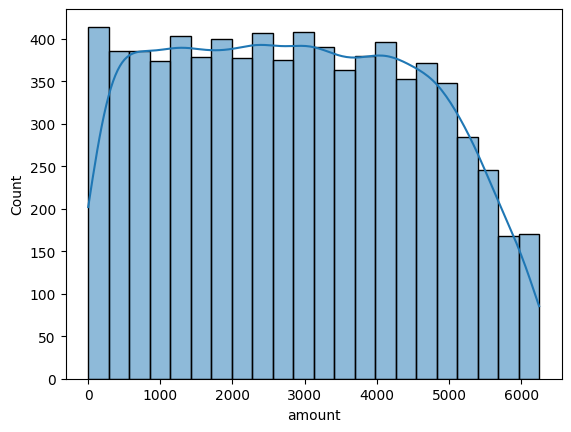

In [18]:
sns.histplot(data=df, x="amount", kde=True)
plt.show()

In [19]:
from src.anomaly_detection.utils.common import label_encode_columns

In [20]:
## Encoding the categorcal features
columns = ["device", "transaction_type", "location"]

df, fitted_encoders = label_encode_columns(df, columns)

print("Encoded DataFrame:\n", df)
print("\nLabel Encoders:", fitted_encoders)

Encoded DataFrame:
                 datetime  ... amount_percentile_user
0    2025-06-01 12:03:31  ...               0.581081
1    2025-06-01 19:19:50  ...               0.297297
2    2025-06-02 19:52:44  ...               0.743243
3    2025-06-03 10:11:53  ...               0.905405
4    2025-06-03 21:23:30  ...               0.770270
...                  ...  ...                    ...
7769 2025-07-24 14:45:45  ...               0.341463
7770 2025-07-25 10:04:10  ...               0.682927
7771 2025-07-25 18:10:43  ...               0.707317
7772 2025-07-27 11:55:14  ...               0.317073
7773 2025-07-29 10:46:11  ...               0.804878

[7774 rows x 23 columns]

Label Encoders: {'device': LabelEncoder(), 'transaction_type': LabelEncoder(), 'location': LabelEncoder()}


In [22]:
features = ['device', 'transaction_type', 'location', 'amount', 
       'day_of_week', 'hour_of_day', 'month', 'quarter',
       'is_weekend', 'day_of_month', 'is_business_hours',
       'transaction_count_last_7_days',
       'average_transaction_amount_last_10_days',
       'days_since_last_transaction', 'unique_locations_used', 'new_device',
       'amount_z_score_user', 'hours_since_last_transaction_user',
       'transaction_count_today_user', 'amount_percentile_user']

print(len(features))

20


In [25]:
iforest = IForest(contamination=0.03, max_features=0.8, random_state=42)
iforest = iforest.fit(df[features])
labels = iforest.labels_
print(labels)

[1 0 0 ... 0 0 0]


In [26]:
all_probs = iforest.predict_proba(df[features])
print(all_probs)

[[0.24967066 0.75032934]
 [0.36865934 0.63134066]
 [0.40016046 0.59983954]
 ...
 [0.76504827 0.23495173]
 [0.49786899 0.50213101]
 [0.62749153 0.37250847]]


c:\Users\user\Desktop\moniepoint\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [ ]:
df[]

In [27]:
outlier = df[features][iforest.labels_ == 1]

In [29]:
outlier_prob = iforest.predict_proba(outlier)
print(outlier_prob[:10])

[[0.24967066 0.75032934]
 [0.05371178 0.94628822]
 [0.33770471 0.66229529]
 [0.34205989 0.65794011]
 [0.31080724 0.68919276]
 [0.15751681 0.84248319]
 [0.25973945 0.74026055]
 [0.33904239 0.66095761]
 [0.29943743 0.70056257]
 [0.29680819 0.70319181]]


c:\Users\user\Desktop\moniepoint\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [31]:
print(outlier_prob[:])

[[0.24967066 0.75032934]
 [0.05371178 0.94628822]
 [0.33770471 0.66229529]
 [0.34205989 0.65794011]
 [0.31080724 0.68919276]
 [0.15751681 0.84248319]
 [0.25973945 0.74026055]
 [0.33904239 0.66095761]
 [0.29943743 0.70056257]
 [0.29680819 0.70319181]
 [0.31495428 0.68504572]
 [0.0906183  0.9093817 ]
 [0.32989144 0.67010856]
 [0.2400714  0.7599286 ]
 [0.32977152 0.67022848]
 [0.11379842 0.88620158]
 [0.34393366 0.65606634]
 [0.32084615 0.67915385]
 [0.14502631 0.85497369]
 [0.21571114 0.78428886]
 [0.3484557  0.6515443 ]
 [0.29855455 0.70144545]
 [0.20551307 0.79448693]
 [0.2938747  0.7061253 ]
 [0.25214856 0.74785144]
 [0.34300218 0.65699782]
 [0.17021175 0.82978825]
 [0.30339266 0.69660734]
 [0.29897145 0.70102855]
 [0.08958978 0.91041022]
 [0.34648673 0.65351327]
 [0.27651995 0.72348005]
 [0.27930537 0.72069463]
 [0.25002422 0.74997578]
 [0.27434386 0.72565614]
 [0.20582824 0.79417176]
 [0.08466158 0.91533842]
 [0.2581875  0.7418125 ]
 [0.29849769 0.70150231]
 [0.28875977 0.71124023]


### Model Explanation, Training and saving for deployment

In [55]:
class AnomalyDetection:
    def __init__(self, model=None):
        self.model = model if model else IsolationForest(contamination=0.03, max_features=0.8, random_state=42)
        self.data = None 
        self.scores = None
        self.labels = None
        self.fitted = False
        self.shap_explainer = None
    
    def fit(self, X: pd.DataFrame):
        self.data = X.copy()  # Store dataset for later reference
        self.model.fit(X)
        self.scores = -self.model.decision_function(X)  # Higher = more anomalous 
        self.labels = np.where(self.model.predict(X) == -1, 1, 0)  # 1=Anomaly, 0=Normal
        self.fitted = True
        
        self.shap_explainer = shap.Explainer(self.model, X)
        
    def top_anomalies(self, n=10):
        """Return top N anomalies."""
        if not self.fitted:
            raise ValueError("Model not fitted yet.")
        top_idx = np.argsort(self.scores)[-n:]
        return self.data.iloc[top_idx], self.scores[top_idx], self.labels[top_idx]

    def plot_shap_summary(self, top_n=10):
        """Plot SHAP feature importance for top anomalies."""
        if not self.fitted:
            raise ValueError("Model not fitted yet.")
        top_idx = np.argsort(self.scores)[-top_n:]
        X = self.data.iloc[top_idx]
        shap_values = self.shap_explainer(X)
        shap.summary_plot(shap_values, X, plot_type="bar")
        
    def plot_feature_contributions(self, anomaly):
        """
        Plot SHAP feature contributions for a single anomaly.
        anomaly: index in self.data or a single row as a pandas Series.
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet.")

        if isinstance(anomaly, pd.Series):
            X_single = anomaly.to_frame().T
        elif anomaly in self.data.index:
            X_single = self.data.loc[[anomaly]]
        else:
            raise ValueError("Provided anomaly must be a valid index or Series from the fitted data.")

        shap_values = self.shap_explainer(X_single)

        # SHAP now returns an Explanation object; use .values for the array
        shap_values_array = shap_values.values[0]

        # Create a DataFrame for better plotting control
        contrib_df = pd.DataFrame({
            "feature": self.data.columns,
            "shap_value": shap_values_array,
            "abs_value": np.abs(shap_values_array)
        }).sort_values("abs_value", ascending=True)

        # Plot a horizontal bar chart
        plt.figure(figsize=(8, 5))
        plt.barh(contrib_df["feature"], contrib_df["shap_value"], color="skyblue")
        plt.axvline(0, color="red", linestyle="--")
        plt.title("Feature Contributions for Selected Anomaly")
        plt.xlabel("SHAP Value (Impact on Model Output)")
        plt.tight_layout()
        plt.show()

    def save_model(self, path="anomaly_detector.joblib"):
        """Save model for deployment."""
        if not self.fitted:
            raise ValueError("Model not fitted yet.")
        joblib.dump({
            "model": self.model
        }, path)

In [56]:
X = df[features]

In [57]:
detector = AnomalyDetection()
detector.fit(X)

In [58]:
# Show top anomalies
top_data, scores, labels = detector.top_anomalies(5)
print(top_data)

      device  ...  amount_percentile_user
6266       1  ...                0.866667
1379       0  ...                0.909774
7623       1  ...                0.881818
74         6  ...                0.914286
1962       5  ...                0.812500

[5 rows x 20 columns]


2025-08-16 01:29:37,032 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-08-16 01:29:37,033 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-16 01:29:37,034 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-08-16 01:29:37,035 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\user\\Desktop\\moniepoint\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal',

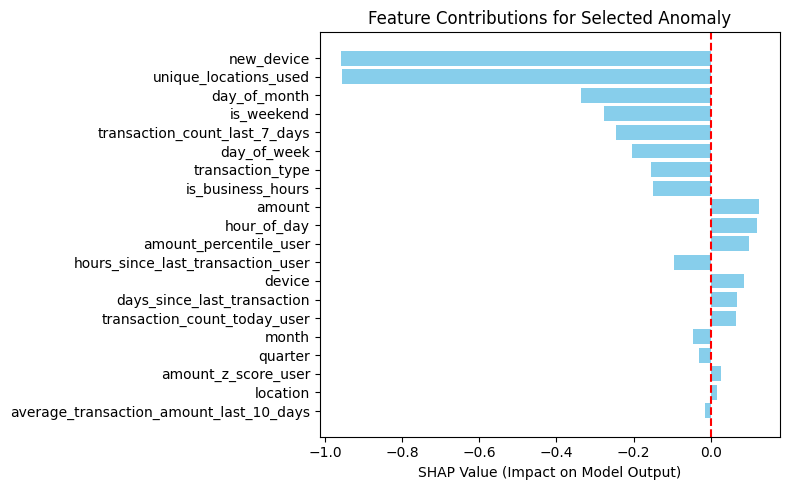

In [59]:
# Assuming you want to explain the first anomaly in the dataset
first_index = X.index[0]
detector.plot_feature_contributions(first_index)

**Ranking**

- Features are sorted by absolute contribution — top = most important for this prediction.

- In the plot:

1. new_device (largest contributor to anomaly score)

2. unique_locations_used (second most important)

3. day_of_month, is_weekend, transaction_count_last_7_days (less but still relevant)

In [63]:
import joblib
from src.anomaly_detection.utils.common import create_directories

# Create the directory for storing the model
create_directories(["artifacts/model/"])

# Define base path
base = "artifacts/model/"

# Save model
detector.save_model(path=f"{base}isolation_forest_model.joblib")

2025-08-16 01:40:40,342 - INFO - Created directory at: artifacts/model/
